In [45]:
import aesara
import jax
import jax.numpy as jnp
import numpy as np
import pymc as pm
import aesara.tensor as at
import matplotlib.pyplot as plt
import seaborn as sns

import pathfinder
import pathfinder.util

print("pymc:",pm.__version__,"aesara:", aesara.__version__)

pymc: 4.0.0 aesara: 2.2.5


Pathfinder can be used with any probabilistic programming framework that provides JAX log probability functions. 

Here's an example with pymc (installed directly from master branch of https://github.com/pymc-devs/pymc)

**WARNING** likely some issue with jax compilation of log-density

#### Data:

In [2]:
J  = 8  # number of schools
y = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float64
)  # treatment effects
sigma = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float64
)  # treatment SE

#### Model:

In [57]:
with pm.Model() as model:

    mu = pm.Normal("mu", mu=0.0, sigma=5.0, shape=1)
    tau = pm.Normal("tau", mu=5.0, sigma=1., shape=1)

    theta = pm.Normal("theta", mu=0, sigma=1, shape=J)
    theta_1 = mu + aesara.tensor.exp(tau) * theta
    obs = pm.Normal("obs", mu=theta_1, sigma=sigma, shape=J, observed=y)

sample_ = model.recompute_initial_point(100)
print("logp at test point:",model.logp(sample_))

logp at test point: -69.59092916389756


In [58]:
transf = pathfinder.util.StackedTensorTransformer([(1,),(1,),(8,)])
unstack_fn = transf.unstack_pure_fn()

sample = list(map(jnp.atleast_2d,sample_.values()))
sample = transf.stack(sample)[0]

Jax compilation of log-density function:

In [59]:
from aesara.graph.fg import FunctionGraph
from aesara.link.jax.dispatch import jax_funcify

for v in model.free_RVs: v.owner = None #otherwise MissingInputError

fgraph = FunctionGraph(model.free_RVs, [model.logpt])

# see https://github.com/pymc-devs/pymc/blob/8a72d37bacfcac0804a74207088bd5d58a0ea495/pymc/sampling_jax.py#L34-L43
@jax_funcify.register(aesara.assert_op.Assert)
def assert_jax(op, **kwargs):
    def fn(value,ins_):
        return value[:]
    return fn

# Jax funcify builds Jax variant of the FunctionGraph.
fns = jax_funcify(fgraph)
logp_fn_jax = fns

logp = jax.vmap(lambda x : logp_fn_jax(*unstack_fn(x))[0])
logp_ = lambda x: logp(jnp.atleast_2d(x))

Unfortunately JAX logp at test point doesn't match logp calculated directly in pymc/aesara:

In [60]:
print("JAX logp at test point:",logp_fn_jax(sample_["mu"], sample_["tau"], sample_["theta"])[0])

JAX logp at test point: -52.2121401505091


#### Pathfinder variational inference:
here we use pathfinder to draw 5000 approximate samples from the posterior distribution of the model:

In [72]:
rng_key = jax.random.PRNGKey(10)
sample = jnp.array(sample)
maxiter = 100
maxcor = 10
M = 5000

elbo, x, phi = pathfinder.pathfinder(rng_key, logp_, sample, maxiter, maxcor, M)

#### Visualization

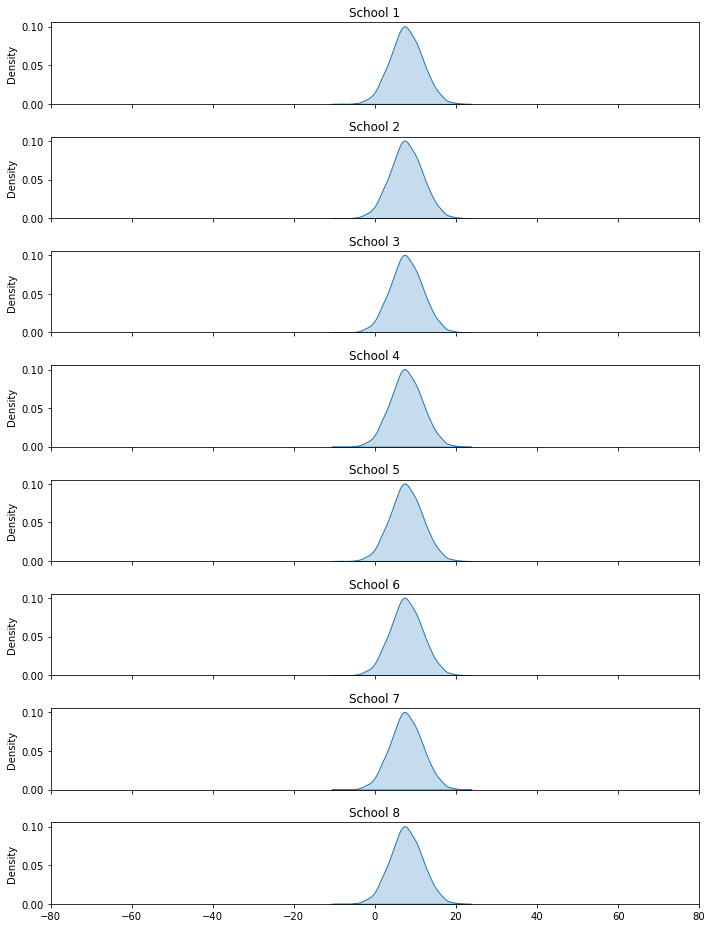

In [73]:
sample_dict = dict(zip(["avg effect", "avg std", "school std"], 
                       unstack_fn(phi)))

school_effect = sample_dict["avg effect"][:,None]+\
                np.exp(sample_dict["avg std"][:,None])*sample_dict["school std"]

fig, axs = plt.subplots(J,1, figsize=(10,13), sharex=True)
for i,ax in zip(range(J),axs):
    sns.kdeplot(school_effect[:, i], ax=ax, shade=True)
    ax.set_title(f"School {i+1}")
ax.set_xlim(-80,80)
fig.tight_layout()